In [1]:
import pandas as pd
import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import darts
import math

In [2]:
# from tqdm.keras import TqdmCallback
# import tensorflow_addons as tfa
# from keras_tqdm import TQDMNotebookCallback

In [3]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [4]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.utils.statistics import plot_acf
from darts.models.arima import ARIMA
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape

Importing plotly failed. Interactive plots will not work.


In [5]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para alocar apenas a memória da GPU necessária para as alocações de tempo de execução
    tf.config.experimental.set_memory_growth(gpus[0], True) 
print(gpus)

[]


In [6]:
print(tf.__version__)
print(tf.keras.__version__)
import keras
print(keras.__version__)

2.1.0
2.2.4-tf
2.3.1


Using TensorFlow backend.


In [7]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential    
from keras.layers import Dense
from keras.layers import Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

from keras.layers import LSTM

In [8]:
root = r'/'
data_path = r'data/dibanez/tesis/data_preprocesada/2.llenada/'

In [9]:
!ls /{data_path}

llenado_Arequipa_UNSA_CIGS_agg_day_hour.csv
llenado_Arequipa_UNSA_HIT_agg_day_hour.csv
llenado_Arequipa_UNSA_PERC_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_CIGS_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv
llenado_Juliaca_UNAJ_CIGS_agg_day_hour.csv
llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv
llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv
llenado_Lima_PUCP_CIGS_agg_day_hour.csv
llenado_Lima_PUCP_HIT_agg_day_hour.csv
llenado_Lima_PUCP_PERC_agg_day_hour.csv
llenado_Tacna_UNJBG_CIGS_agg_day_hour.csv
llenado_Tacna_UNJBG_HIT_agg_day_hour.csv
llenado_Tacna_UNJBG_PERC_agg_day_hour.csv


# Preparación y Entrenamiento

## Lectura de datos

In [11]:
def print_df(df):
  print(df.shape)
  return df.head()

In [12]:
data_file = data_path+'llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv'

In [10]:
data_file_Juliaca = data_path+'llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv'

In [13]:
df = pd.read_csv(root+data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(3145, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-01-19 07:00:00,NaN,15.481038,126.680377,280.261225,0.663656,169.232893,127.25,188.702179
1,1,2021-01-19 08:00:00,NaN,21.373603,243.603396,286.352633,1.309358,352.285000,259.25,376.508333
2,2,2021-01-19 09:00:00,NaN,27.428326,326.799399,284.905883,1.737817,468.926667,488.50,495.450000
3,3,2021-01-19 10:00:00,NaN,35.033718,519.406319,284.755117,2.515042,682.881667,610.75,714.733333
4,4,2021-01-19 11:00:00,NaN,38.094180,621.082664,284.442400,2.985145,813.890000,434.75,850.175000


In [14]:
df_Juliaca = pd.read_csv(root+data_file_Juliaca, parse_dates=True)
df_Juliaca.Fecha = pd.to_datetime(df_Juliaca.Fecha)
df_Juliaca=df_Juliaca.reset_index()
print_df(df_Juliaca)

(2098, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-04-24 09:00:00,NaN,34.972500,NaN,280.775139,4.749689,1280.711111,725.25,1335.512452
1,1,2021-04-24 10:00:00,NaN,35.085333,NaN,286.157139,4.822428,1329.452778,1422.00,1383.670669
2,2,2021-04-24 11:00:00,NaN,40.175500,NaN,292.318028,4.879322,1379.002778,1152.00,1433.825000
3,3,2021-04-24 12:00:00,NaN,44.957333,NaN,288.280642,4.392036,1229.313272,1463.75,1278.857407
4,4,2021-04-24 13:00:00,NaN,39.497586,NaN,282.816713,4.245637,1154.008380,1480.75,1203.392830


In [15]:
df.isna().sum()/len(df)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    0.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
dtype: float64

In [16]:
df_Juliaca.isna().sum()/len(df_Juliaca)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    1.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
dtype: float64

## Codificación de fechas


In [28]:
start = df.iloc[0]['Fecha']
start

Timestamp('2021-01-19 07:00:00')

In [29]:
start_J = df_Juliaca.iloc[0]['Fecha']
start_J

Timestamp('2021-04-24 09:00:00')

In [30]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
df.head(13)

,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
0,0,2021-01-19 07:00:00,NaN,15.481038,126.680377,280.261225,0.663656,169.232893,127.250000,188.702179,2021-01-19 07:00:00
1,1,2021-01-19 08:00:00,NaN,21.373603,243.603396,286.352633,1.309358,352.285000,259.250000,376.508333,2021-01-19 08:00:00
2,2,2021-01-19 09:00:00,NaN,27.428326,326.799399,284.905883,1.737817,468.926667,488.500000,495.450000,2021-01-19 09:00:00
3,3,2021-01-19 10:00:00,NaN,35.033718,519.406319,284.755117,2.515042,682.881667,610.750000,714.733333,2021-01-19 10:00:00
4,4,2021-01-19 11:00:00,NaN,38.094180,621.082664,284.442400,2.985145,813.890000,434.750000,850.175000,2021-01-19 11:00:00
5,5,2021-01-19 12:00:00,NaN,43.941246,791.262844,286.243400,3.428338,945.055000,290.500000,985.250000,2021-01-19 12:00:00
6,6,2021-01-19 13:00:00,NaN,37.725523,596.098252,284.086433,2.645817,720.548333,902.500000,754.668333,2021-01-19 13:00:00
7,7,2021-01-19 14:00:00,NaN,34.077905,575.606230,285.852883,2.642738,721.798333,681.750000,754.813333,2021-01-19 14:00:00
8,8,2021-01-19 15:00:00,NaN,32.345680,425.935810,283.860767,2.158502,583.478333,340.750000,613.145000,2021-01-19 15:00:00
9,9,2021-01-19 16:00:00,NaN,26.037586,268.995017,282.339650,1.421920,378.303333,141.500000,402.638333,2021-01-19 16:00:00


In [31]:
fechas_origen = df.Fecha

In [32]:
fechas_origen[:11+1]

0    2021-01-19 07:00:00
1    2021-01-19 08:00:00
2    2021-01-19 09:00:00
3    2021-01-19 10:00:00
4    2021-01-19 11:00:00
5    2021-01-19 12:00:00
6    2021-01-19 13:00:00
7    2021-01-19 14:00:00
8    2021-01-19 15:00:00
9    2021-01-19 16:00:00
10   2021-01-20 06:00:00
11   2021-01-20 07:00:00
Name: Fecha, dtype: datetime64[ns]

In [33]:
df_Juliaca['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df_Juliaca))
df_Juliaca.head(13)

,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
0,0,2021-04-24 09:00:00,NaN,34.972500,NaN,280.775139,4.749689,1280.711111,725.250000,1335.512452,2021-01-19 07:00:00
1,1,2021-04-24 10:00:00,NaN,35.085333,NaN,286.157139,4.822428,1329.452778,1422.000000,1383.670669,2021-01-19 08:00:00
2,2,2021-04-24 11:00:00,NaN,40.175500,NaN,292.318028,4.879322,1379.002778,1152.000000,1433.825000,2021-01-19 09:00:00
3,3,2021-04-24 12:00:00,NaN,44.957333,NaN,288.280642,4.392036,1229.313272,1463.750000,1278.857407,2021-01-19 10:00:00
4,4,2021-04-24 13:00:00,NaN,39.497586,NaN,282.816713,4.245637,1154.008380,1480.750000,1203.392830,2021-01-19 11:00:00
5,5,2021-04-24 14:00:00,NaN,37.260500,NaN,282.096028,3.473319,939.611111,1286.250000,980.427778,2021-01-19 12:00:00
6,6,2021-04-24 15:00:00,NaN,29.957288,NaN,287.862333,1.967956,543.602778,925.500000,569.852778,2021-01-19 13:00:00
7,7,2021-04-24 16:00:00,NaN,17.351167,NaN,282.548028,0.764306,215.227778,348.250000,228.853105,2021-01-19 14:00:00
8,8,2021-04-25 06:00:00,NaN,-0.059831,NaN,279.814310,0.814707,221.379310,216.315789,237.333333,2021-01-19 15:00:00
9,9,2021-04-25 07:00:00,NaN,15.071525,NaN,301.611167,2.346783,675.850000,673.566667,705.216667,2021-01-19 16:00:00


In [34]:
fechas_origen_Target = df_Juliaca.Fecha

In [35]:
fechas_origen_Target[:11+1]

0    2021-04-24 09:00:00
1    2021-04-24 10:00:00
2    2021-04-24 11:00:00
3    2021-04-24 12:00:00
4    2021-04-24 13:00:00
5    2021-04-24 14:00:00
6    2021-04-24 15:00:00
7    2021-04-24 16:00:00
8    2021-04-25 06:00:00
9    2021-04-25 07:00:00
10   2021-04-25 08:00:00
11   2021-04-25 09:00:00
Name: Fecha, dtype: datetime64[ns]

## Preprocesamiento

In [36]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', ['Pac','Tmod'])#,'Irradiancia'])#, freq='H')
type(series_raw)

darts.timeseries.TimeSeries

In [37]:
col_obj = 'Pac'

In [38]:
series_raw[col_obj]

                             Pac
Fecha_cod                       
2021-01-19 07:00:00   127.250000
2021-01-19 08:00:00   259.250000
2021-01-19 09:00:00   488.500000
2021-01-19 10:00:00   610.750000
2021-01-19 11:00:00   434.750000
...                          ...
2021-05-30 03:00:00  1402.250000
2021-05-30 04:00:00  1448.083333
2021-05-30 05:00:00  1115.516667
2021-05-30 06:00:00   560.266667
2021-05-30 07:00:00   295.978261

[3145 rows x 1 columns]
Freq: H

In [39]:
series_raw[col_obj][:12]

                            Pac
Fecha_cod                      
2021-01-19 07:00:00  127.250000
2021-01-19 08:00:00  259.250000
2021-01-19 09:00:00  488.500000
2021-01-19 10:00:00  610.750000
2021-01-19 11:00:00  434.750000
2021-01-19 12:00:00  290.500000
2021-01-19 13:00:00  902.500000
2021-01-19 14:00:00  681.750000
2021-01-19 15:00:00  340.750000
2021-01-19 16:00:00  141.500000
2021-01-19 17:00:00   58.259686
2021-01-19 18:00:00  163.125951
Freq: H

In [40]:
len(series_raw)

3145

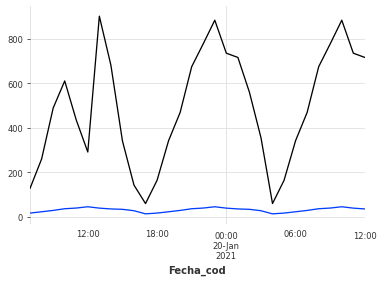

In [41]:
series_raw[0:30].plot()

In [42]:
series_raw_Target = TimeSeries.from_dataframe(df_Juliaca, 'Fecha_cod', ['Pac','Tmod'])#,'Irradiancia'])#, freq='H')
type(series_raw_Target)

darts.timeseries.TimeSeries

In [43]:
col_obj = 'Pac'

In [44]:
series_raw_Target[col_obj]

                         Pac
Fecha_cod                   
2021-01-19 07:00:00   725.25
2021-01-19 08:00:00  1422.00
2021-01-19 09:00:00  1152.00
2021-01-19 10:00:00  1463.75
2021-01-19 11:00:00  1480.75
...                      ...
2021-04-16 12:00:00  1420.25
2021-04-16 13:00:00   742.50
2021-04-16 14:00:00   364.50
2021-04-16 15:00:00   177.50
2021-04-16 16:00:00   230.00

[2098 rows x 1 columns]
Freq: H

In [45]:
series_raw_Target[col_obj][:12]

                             Pac
Fecha_cod                       
2021-01-19 07:00:00   725.250000
2021-01-19 08:00:00  1422.000000
2021-01-19 09:00:00  1152.000000
2021-01-19 10:00:00  1463.750000
2021-01-19 11:00:00  1480.750000
2021-01-19 12:00:00  1286.250000
2021-01-19 13:00:00   925.500000
2021-01-19 14:00:00   348.250000
2021-01-19 15:00:00   216.315789
2021-01-19 16:00:00   673.566667
2021-01-19 17:00:00  1055.450000
2021-01-19 18:00:00  1335.983333
Freq: H

In [46]:
len(series_raw_Target)

2098

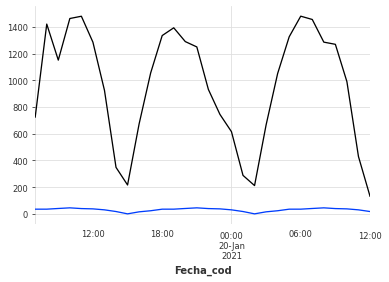

In [47]:
series_raw_Target[0:30].plot()

### Imputación de datos faltantes

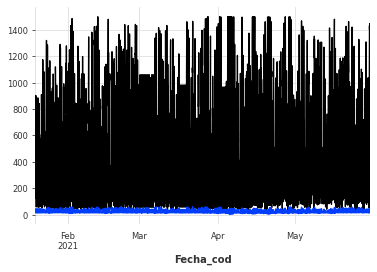

In [48]:
series_raw.plot()

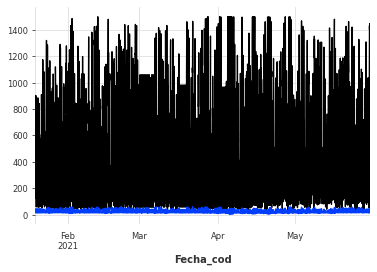

In [49]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

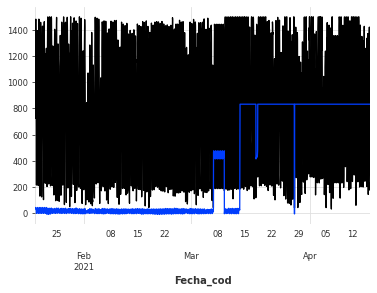

In [50]:
series_raw_Target.plot()

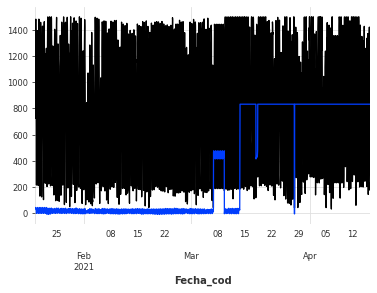

In [51]:
# TODO
filler = MissingValuesFiller()
series_Target = filler.transform(series_raw_Target, method='linear')
series_Target.plot()

### Separación de conjuntos de entrenamiento y validación

In [52]:
train_perc = .8
math.ceil(len(series)*train_perc)

2516

In [53]:
val_len = int(len(series)*(1-train_perc))

In [54]:
val_len -= val_len%11

In [55]:
val_len

627

In [56]:
train, val = series[:-val_len], series[-val_len:]

In [57]:
train

                             Pac       Tmod
Fecha_cod                                  
2021-01-19 07:00:00   127.250000  15.481038
2021-01-19 08:00:00   259.250000  21.373603
2021-01-19 09:00:00   488.500000  27.428326
2021-01-19 10:00:00   610.750000  35.033718
2021-01-19 11:00:00   434.750000  38.094180
...                          ...        ...
2021-05-04 00:00:00  1428.016667  44.840167
2021-05-04 01:00:00   960.700000  39.529333
2021-05-04 02:00:00   773.633333  34.640345
2021-05-04 03:00:00   969.033333  34.755000
2021-05-04 04:00:00   341.733333  25.252542

[2518 rows x 2 columns]
Freq: H

In [58]:
train_perc = .8
math.ceil(len(series_Target)*train_perc)

1679

In [59]:
val_len = int(len(series_Target)*(1-train_perc))

In [60]:
val_len -= val_len%11

In [61]:
val_len

418

In [62]:
train_Target, val_Target = series[:-val_len], series[-val_len:]

In [63]:
train_Target

                            Pac       Tmod
Fecha_cod                                 
2021-01-19 07:00:00  127.250000  15.481038
2021-01-19 08:00:00  259.250000  21.373603
2021-01-19 09:00:00  488.500000  27.428326
2021-01-19 10:00:00  610.750000  35.033718
2021-01-19 11:00:00  434.750000  38.094180
...                         ...        ...
2021-05-12 17:00:00  905.600000  30.322833
2021-05-12 18:00:00  824.483333  27.029000
2021-05-12 19:00:00  684.050000  27.344667
2021-05-12 20:00:00  323.416667  21.497119
2021-05-12 21:00:00  273.516667  20.139000

[2727 rows x 2 columns]
Freq: H

In [130]:
# plot_acf(train)

## Visualización

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

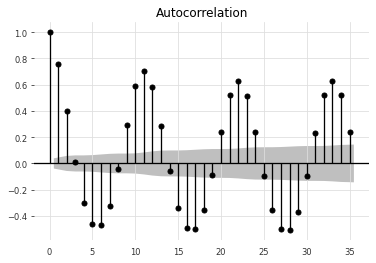

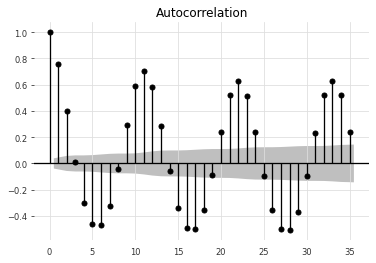

In [66]:
plot_acf(train[col_obj].values())

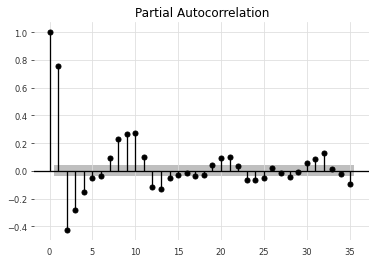

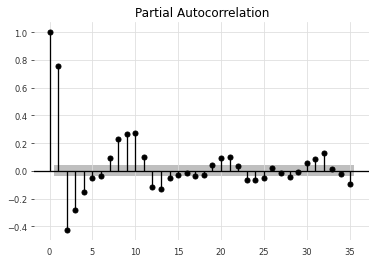

In [67]:
plot_pacf(train[col_obj].values())

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

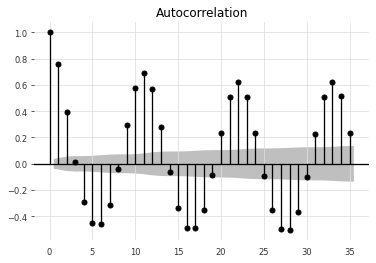

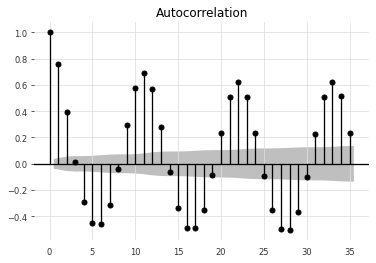

In [69]:
plot_acf(train_Target[col_obj].values())

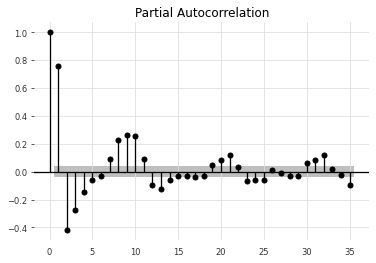

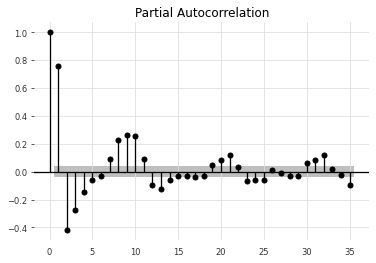

In [70]:
plot_pacf(train_Target[col_obj].values())

## Training (CNN)

In [71]:
df_columns = ['Pac', 'Tmod']#,'Irradiancia']

In [73]:
arr_train_Target = train_Target.values()
arr_train_Target

array([[127.25      ,  15.48103781],
       [259.25      ,  21.37360297],
       [488.5       ,  27.42832607],
       ...,
       [684.05      ,  27.34466667],
       [323.41666667,  21.49711864],
       [273.51666667,  20.139     ]])

In [74]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [76]:
n_steps_in, n_steps_out = 11, 11
X_Target, y_Target = split_sequences(arr_train_Target, n_steps_in, n_steps_out)
print(X_Target.shape, y_Target.shape)

(2706, 11, 2) (2706, 11)


In [77]:
print(X_Target[0], y_Target[0])

[[127.25        15.48103781]
 [259.25        21.37360297]
 [488.5         27.42832607]
 [610.75        35.03371835]
 [434.75        38.09417994]
 [290.5         43.94124555]
 [902.5         37.7255226 ]
 [681.75        34.07790476]
 [340.75        32.34567958]
 [141.5         26.03758612]
 [ 58.25968552  11.96111905]] [163.12595127 341.9530303  469.10909091 675.05454545 778.13939394
 884.33787879 735.65606061 716.6        559.89242424 354.99848485
  58.25968552]


In [78]:
X_Target.shape

(2706, 11, 2)

In [79]:
y_Target.shape

(2706, 11)

### Transfer learning from Chachapoyas to Juliaca

In [104]:
cnn_chachapoyas = tf.keras.models.load_model('saved_models/1dcnn_Chachapoyas_HIT')

# Check its architecture
cnn_chachapoyas.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [105]:
cnn_chachapoyas.layers

In [106]:
# Freeze weights
cnn_chachapoyas.layers[0].trainable = False

In [107]:
cnn_chachapoyas.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 17,251
Trainable params: 16,931
Non-trainable params: 320
_________________________________________________________________


In [108]:
chachapoyas_original_weights_values = cnn_chachapoyas.get_weights()


In [109]:
cnn_chachapoyas.compile(optimizer='adam', loss='mse')


In [ ]:
%%time
hist_cnn_transfer = cnn_chachapoyas.fit(X, y, epochs=3500, verbose=1)

Train on 2497 samples
Epoch 1/3500
2497/2497 [==============================] - 0s 176us/sample - loss: 28187.4050
Epoch 2/3500
2497/2497 [==============================] - 0s 93us/sample - loss: 28371.1098
Epoch 3/3500
2497/2497 [==============================] - 0s 88us/sample - loss: 27920.2451
Epoch 4/3500
2497/2497 [==============================] - 0s 88us/sample - loss: 28035.9012
Epoch 5/3500
2497/2497 [==============================] - 0s 93us/sample - loss: 28052.9463
Epoch 6/3500
2497/2497 [==============================] - 0s 90us/sample - loss: 28492.2542
Epoch 7/3500
2497/2497 [==============================] - 0s 93us/sample - loss: 27932.1692
Epoch 8/3500
2497/2497 [==============================] - 0s 87us/sample - loss: 28183.8199
Epoch 9/3500
2497/2497 [==============================] - 0s 89us/sample - loss: 28094.3935
Epoch 10/3500
2497/2497 [==============================] - 0s 83us/sample - loss: 28197.0567
Epoch 11/3500
2497/2497 [==============================]

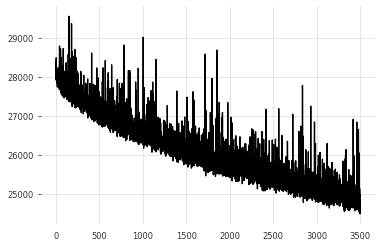

In [111]:
plt.plot(hist_cnn_transfer.history['loss'])

In [112]:
cnn_juliaca_transfered = cnn_chachapoyas
cnn_juliaca_transfered.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,611
Non-trainable params: 320
_________________________________________________________________


### Sin transferencia

In [ ]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   


# define el modelo
modelo_cnn = Sequential()
modelo_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
modelo_cnn.add(MaxPooling1D(pool_size=2))
modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(50, activation='relu'))
modelo_cnn.add(Dense(n_steps_out))
modelo_cnn.compile(optimizer='adam', loss='mse')

# entrena el modelo Vector-Output Mulkti-step MLP con la la data de entrenamiento generada
hist_cnn = modelo_cnn.fit(X_Target, y_Target, epochs=3500, verbose=1)#, callbacks=[TqdmCallback(verbose=2)])




Epoch 1/3500
2706/2706 [==============================] - 0s 119us/step - loss: 151472.5154
Epoch 2/3500
2706/2706 [==============================] - 0s 86us/step - loss: 80139.3889
Epoch 3/3500
2706/2706 [==============================] - 0s 91us/step - loss: 77392.5777
Epoch 4/3500
2706/2706 [==============================] - 0s 90us/step - loss: 75770.8139
Epoch 5/3500
2706/2706 [==============================] - 0s 89us/step - loss: 74485.7088
Epoch 6/3500
2706/2706 [==============================] - 0s 90us/step - loss: 73406.5749
Epoch 7/3500
2706/2706 [==============================] - 0s 87us/step - loss: 72211.0788
Epoch 8/3500
2706/2706 [==============================] - 0s 84us/step - loss: 71325.3067
Epoch 9/3500
2706/2706 [==============================] - 0s 89us/step - loss: 70671.2046
Epoch 10/3500
2706/2706 [==============================] - 0s 88us/step - loss: 69727.3768
Epoch 11/3500
2706/2706 [==============================] - 0s 91us/step - loss: 69238.2187
Epoch 

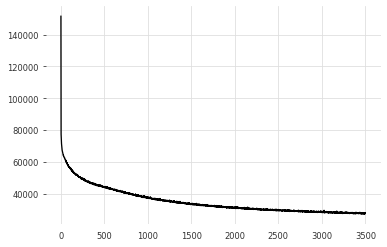

In [119]:
plt.plot(hist_cnn.history['loss'])

In [120]:
cnn_juliaca_sin_transferencia = modelo_cnn

In [121]:
# muestra un resumen de la topologia del modelo
cnn_juliaca_sin_transferencia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [72]:
# modelo_cnn = modelo

In [73]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 13ms/step


array([[  62.8322 ,  202.66614,  518.1393 ,  894.1688 , 1236.1995 ,
        1331.9559 , 1233.2562 , 1031.9458 ,  855.175  ,  734.057  ,
         461.90106]], dtype=float32)

In [74]:
modelo_cnn.save('saved_models/1dcnn_Chachapoyas_HIT') #Pac, Tamb

# Comparación de modelos

#### Walk forward para modelos neuronales

In [122]:
def walk_forward_evaluation_neuronal(train, val, model, n_pred, col_obj, es_neuronal=True):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    x_input = train[-11:]
    if es_neuronal:
        pass #model.fit(train)
    
    arr_pred=None
    arr_real=None 
    for t in range(val.shape[0]-n_pred):
        if (t%100 == 0) or (t == (val.shape[0]-n_pred-1)):
            print(f't={t}/{val.shape[0]-n_pred-1}')
            print(f'history len = {x_input.shape[0]}')
            print()
        
        #valores predichos
        if not es_neuronal:
#             model.fit(history[col_obj])
            pred = model.predict(n_pred)
        else:
            pred = model.predict(x_input.reshape((1, 11, train.shape[1])) )
            
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
            
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        if not es_neuronal:
            real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        else:
            real = val[t:t+n_pred,0].reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        x_input = np.vstack((x_input[1:],val[t]))
    
    return arr_pred, arr_real
    

In [ ]:
train[-200:].plot()
val[col_obj][:n_predict].plot()
pred.plot()

In [ ]:
## Modelo transferido (Origen: Chachapoyas, Destino: Juliaca)

## Modelo no transferido (Entrenado: Juliaca, Probado: Juliaca)

## Modelo no transferido (Entrenado: Chachapoyas, Probado: Juliaca)
